In [1]:
import sys
import os
from pathlib import Path

sys.path.append(os.path.abspath(".."))

import torch
import numpy as np
import umap
import matplotlib.pyplot as plt


from utils.data import (
    download_mnist_data,
    get_mnist_image_np_arrays,
    get_mnnist_labels_np_arrays,
    UMAPImageDataset,
    ClassificationDataset,
)
from utils.autoencoder import MNISTAutoencoder
from utils.loss import UMAPAutoencoderLoss
from utils.train_functions import (
    train_autoencoder,
    train_autoencoder_with_umap,
    test_autoencoder_reconstruction,
    test_autoencoder_umap_embedding,
)

# Load MNIST images

In [2]:
# Skips downloading if data is already present
download_mnist_data()

Data is already downloaded. Skipping download.


In [3]:
train_images, test_images = get_mnist_image_np_arrays()

# Labels for visualization purposes
train_labels, test_labels = get_mnnist_labels_np_arrays()

# UMAP embeddings

## Generate  & save embeddings

In [4]:
# COMMENTED OUT TO AVOID REGENERATING UMAP EMBEDDINGS
# Remove comments to regenerate UMAP embeddings

# embedding_dim = 2

# full_images = np.concatenate([train_images, test_images], axis=0)
# flat_full_images = full_images.reshape(full_images.shape[0], -1)
# reducer = umap.UMAP(n_components=embedding_dim)
# full_embeddings = reducer.fit_transform(flat_full_images)

# train_embeddings = full_embeddings[: len(train_images)]
# test_embeddings = full_embeddings[len(train_images) :]

# # Save full embeddings to a file
# project_dir = Path("..").resolve()
# embeddings_file = (
#     project_dir
#     / "data"
#     / "mnist"
#     / "umap_embeddings"
#     / f"embeddings_d{embedding_dim}.npy"
# )
# embeddings_file.parent.mkdir(parents=True, exist_ok=True)
# np.save(embeddings_file, full_embeddings)


## Load embeddings (if already saved)

In [5]:
embedding_dim = 2

project_dir = Path("..").resolve()
data_dir = project_dir / "data" / "mnist" / "umap_embeddings"
embeddings_file = data_dir / f"embeddings_d{embedding_dim}.npy"

full_embeddings = np.load(embeddings_file)
full_images = np.concatenate([train_images, test_images], axis=0)
flat_full_images = full_images.reshape(full_images.shape[0], -1)

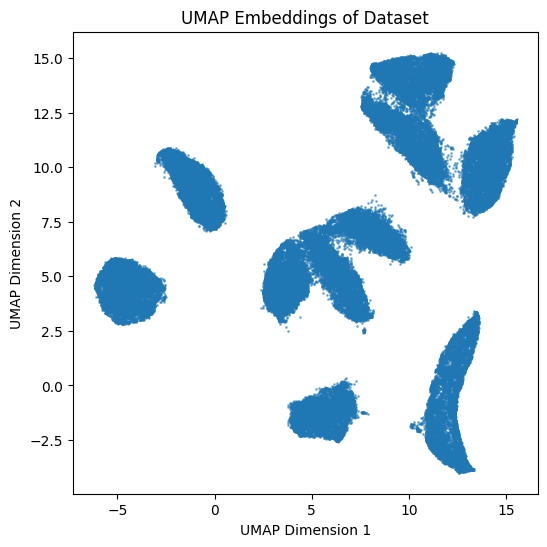

In [6]:
# Plot embeddings
plt.figure(figsize=(6, 6))
plt.scatter(full_embeddings[:, 0], full_embeddings[:, 1], s=1, alpha=0.5)
plt.title("UMAP Embeddings of Dataset")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()


# Train Autoencoders

## Train & Test split

In [7]:
# Datasets
flat_train_images = train_images.reshape(train_images.shape[0], -1)
flat_test_images = test_images.reshape(test_images.shape[0], -1)

train_embeddings = full_embeddings[: len(train_images)]
test_embeddings = full_embeddings[len(train_images) :]

flat_train_dataset = UMAPImageDataset(
    images=flat_train_images, umap_embeddings=train_embeddings
)
flat_test_dataset = UMAPImageDataset(
    images=flat_test_images, umap_embeddings=test_embeddings
)

flat_train_loader = torch.utils.data.DataLoader(
    flat_train_dataset, batch_size=128, shuffle=True
)
flat_test_loader = torch.utils.data.DataLoader(
    flat_test_dataset, batch_size=128, shuffle=False
)

## Create models

In [8]:
autoencoder_input_dim = flat_full_images.shape[1]
umap_autoencoder = MNISTAutoencoder(
    input_dim=autoencoder_input_dim, embedding_dim=embedding_dim
)
normal_autoencoder = MNISTAutoencoder(
    input_dim=autoencoder_input_dim, embedding_dim=embedding_dim
)
print(umap_autoencoder)

MNISTAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


## Train normal Autoencoder

In [9]:
# Train
normal_criterion = torch.nn.MSELoss()
normal_optimizer = torch.optim.Adam(normal_autoencoder.parameters(), lr=1e-3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else device)

normal_num_epochs = 5

train_autoencoder(
    model=normal_autoencoder,
    dataloader=flat_train_loader,
    criterion=normal_criterion,
    optimizer=normal_optimizer,
    num_epochs=normal_num_epochs,
    device=device,
)

Epoch [1/5], Loss: 0.0550
Epoch [2/5], Loss: 0.0442
Epoch [3/5], Loss: 0.0419
Epoch [4/5], Loss: 0.0406
Epoch [5/5], Loss: 0.0395
Training complete.


## Train Autoencoder with UMAP as teacher

In [10]:
# Train
umap_criterion = UMAPAutoencoderLoss(reconstruction_weight=0.5, umap_weight=0.5)
umap_optimizer = torch.optim.Adam(umap_autoencoder.parameters(), lr=1e-3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else device)

umap_num_epochs = 20

train_autoencoder_with_umap(
    model=umap_autoencoder,
    dataloader=flat_train_loader,
    criterion=umap_criterion,
    optimizer=umap_optimizer,
    num_epochs=umap_num_epochs,
    device=device,
)


Epoch [1/20], Loss: 2.7681
Epoch [2/20], Loss: 0.7771
Epoch [3/20], Loss: 0.5514
Epoch [4/20], Loss: 0.4300
Epoch [5/20], Loss: 0.3530
Epoch [6/20], Loss: 0.2973
Epoch [7/20], Loss: 0.2491
Epoch [8/20], Loss: 0.2125
Epoch [9/20], Loss: 0.1795
Epoch [10/20], Loss: 0.1597
Epoch [11/20], Loss: 0.1415
Epoch [12/20], Loss: 0.1289
Epoch [13/20], Loss: 0.1099
Epoch [14/20], Loss: 0.1013
Epoch [15/20], Loss: 0.0939
Epoch [16/20], Loss: 0.0915
Epoch [17/20], Loss: 0.0849
Epoch [18/20], Loss: 0.0791
Epoch [19/20], Loss: 0.0749
Epoch [20/20], Loss: 0.0724
Training complete.


# Compare results

## Compare image results

### Plot normal Autoencoder results

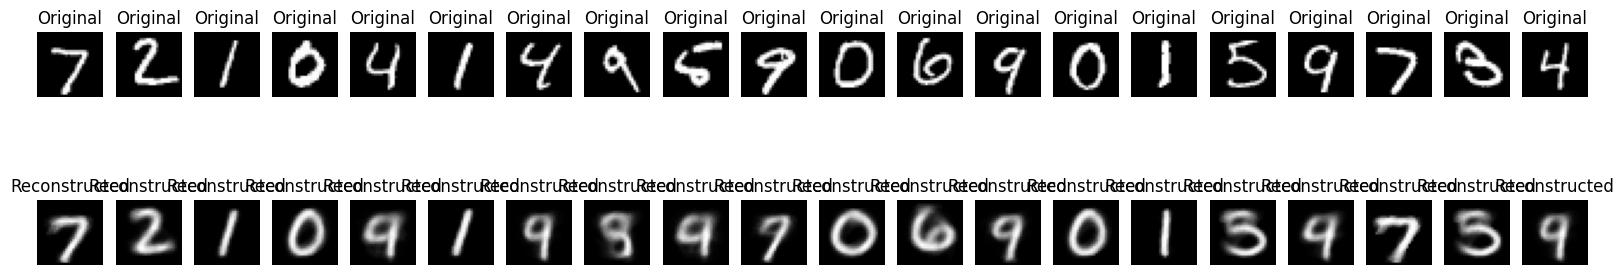

In [11]:
# Plot example image and reconstructions
normal_autoencoder.eval()
with torch.no_grad():
    sample_images, _ = next(iter(flat_test_loader))
    sample_images = sample_images.to(device).float()
    reconstructed = normal_autoencoder(sample_images).cpu().numpy()
    sample_images = sample_images.cpu().numpy()
    n = 20
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(sample_images[i].reshape(28, 28), cmap="gray")
        plt.title("Original")
        plt.axis("off")

        # Reconstructed
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap="gray")
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

### Plot UMAP Autoecoder results

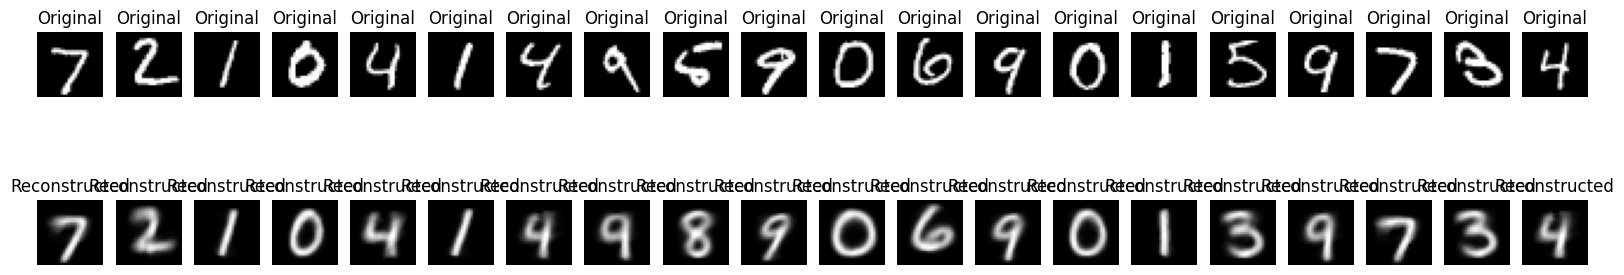

In [12]:
# Plot example image and reconstructions
umap_autoencoder.eval()
with torch.no_grad():
    sample_images, _ = next(iter(flat_test_loader))
    sample_images = sample_images.to(device).float()
    reconstructed = umap_autoencoder(sample_images).cpu().numpy()
    sample_images = sample_images.cpu().numpy()
    n = 20
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(sample_images[i].reshape(28, 28), cmap="gray")
        plt.title("Original")
        plt.axis("off")

        # Reconstructed
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap="gray")
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

## Compare Metrics

In [13]:
# Test
normal_reconstruction_loss = test_autoencoder_reconstruction(
    normal_autoencoder, flat_test_loader, device
)
umap_reconstruction_loss = test_autoencoder_reconstruction(
    umap_autoencoder, flat_test_loader, device
)

print(f"Normal Autoencoder Reconstruction Loss: {normal_reconstruction_loss:.4f}")
print(f"UMAP Autoencoder Reconstruction Loss: {umap_reconstruction_loss:.4f}")

Normal Autoencoder Reconstruction Loss: 0.0395
UMAP Autoencoder Reconstruction Loss: 0.0399


In [14]:
normal_umap_embedding_loss = test_autoencoder_umap_embedding(
    normal_autoencoder, flat_test_loader, device
)
umap_umap_embedding_loss = test_autoencoder_umap_embedding(
    umap_autoencoder, flat_test_loader, device
)

print(f"Normal Autoencoder UMAP Embedding Loss: {normal_umap_embedding_loss:.4f}")
print(f"UMAP Autoencoder UMAP Embedding Loss: {umap_umap_embedding_loss:.4f}")

Normal Autoencoder UMAP Embedding Loss: 86.2496
UMAP Autoencoder UMAP Embedding Loss: 0.7072


## Compare latent spaces

### Normal Autoencoder latent space

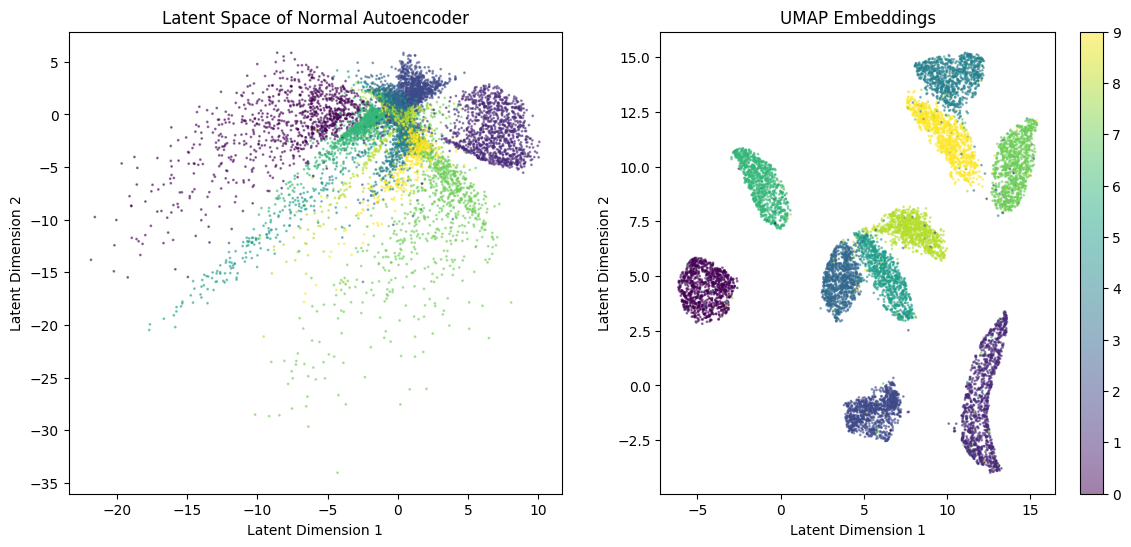

In [15]:
normal_autoencoder.eval()
all_latents = []
with torch.no_grad():
    for images, _ in flat_test_loader:
        images = images.to(device).float()
        latents = normal_autoencoder.encoder(images).cpu().numpy()
        all_latents.append(latents)
all_latents = np.concatenate(all_latents, axis=0)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
# Set colors depending on label
colors = test_labels.argmax(axis=1)

ax[0].scatter(
    all_latents[:, 0],
    all_latents[:, 1],
    s=1,
    alpha=0.5,
    c=colors,
    label="Normal Autoencoder",
)

ax[1].scatter(
    test_embeddings[:, 0],
    test_embeddings[:, 1],
    s=1,
    alpha=0.5,
    c=colors,
    label="UMAP Embeddings",
)

ax[0].set_title("Latent Space of Normal Autoencoder")
ax[0].set_xlabel("Latent Dimension 1")
ax[0].set_ylabel("Latent Dimension 2")
ax[1].set_title("UMAP Embeddings")
ax[1].set_xlabel("Latent Dimension 1")
ax[1].set_ylabel("Latent Dimension 2")
plt.colorbar(ax[1].collections[0], ax=ax[1])
plt.show()

### UMAP Autoencoder latent space

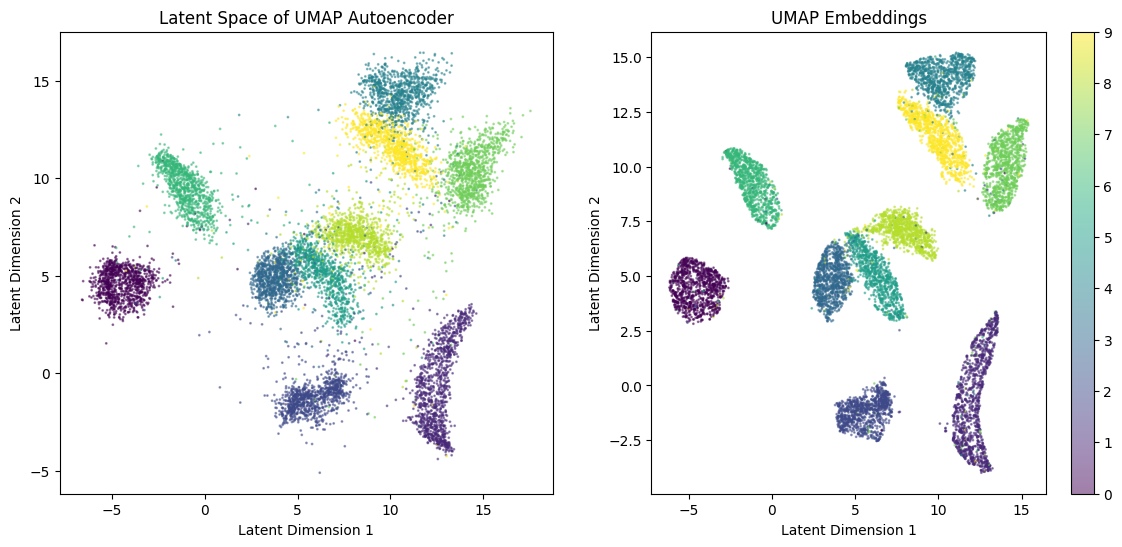

In [16]:
umap_autoencoder.eval()
all_latents = []
with torch.no_grad():
    for images, _ in flat_test_loader:
        images = images.to(device).float()
        latents = umap_autoencoder.encoder(images).cpu().numpy()
        all_latents.append(latents)
all_latents = np.concatenate(all_latents, axis=0)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
# Set colors depending on label
colors = test_labels.argmax(axis=1)

ax[0].scatter(
    all_latents[:, 0],
    all_latents[:, 1],
    s=1,
    alpha=0.5,
    c=colors,
    label="Normal Autoencoder",
)

ax[1].scatter(
    test_embeddings[:, 0],
    test_embeddings[:, 1],
    s=1,
    alpha=0.5,
    c=colors,
    label="UMAP Embeddings",
)

ax[0].set_title("Latent Space of UMAP Autoencoder")
ax[0].set_xlabel("Latent Dimension 1")
ax[0].set_ylabel("Latent Dimension 2")
ax[1].set_title("UMAP Embeddings")
ax[1].set_xlabel("Latent Dimension 1")
ax[1].set_ylabel("Latent Dimension 2")
plt.colorbar(ax[1].collections[0], ax=ax[1])
plt.show()


# Train Classification model and test on reconstructed data

In [17]:
class MLPClassifier(torch.nn.Module):
    def __init__(self, in_channels, num_classes):
        super(MLPClassifier, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels, 32, kernel_size=3, stride=2, padding=1
            ),  # 28→14
            torch.nn.Dropout(0.5),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 14→7
            torch.nn.Dropout(0.5),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, num_classes, kernel_size=7, stride=1, padding=0),  # 7→1
            torch.nn.Softmax(dim=1),
        )

    def forward(self, x):
        x = self.layers(x)
        return x.squeeze()

In [18]:
def train_classifier(model, dataloader, criterion, optimizer, num_epochs, device):
    model.to(device)
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs = inputs.float().to(device)
            labels = labels.float().to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(dataloader.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")


In [19]:
classifier = MLPClassifier(in_channels=1, num_classes=10)

# flat_train_images = train_images.reshape(train_images.shape[0], -1)
# flat_test_images = test_images.reshape(test_images.shape[0], -1)

train_images = train_images.reshape(-1, 1, 28, 28)
test_images = test_images.reshape(-1, 1, 28, 28)

train_dataset = ClassificationDataset(images=train_images, labels=train_labels)
test_dataset = ClassificationDataset(images=test_images, labels=test_labels)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else device)

num_epochs = 5
train_classifier(
    model=classifier,
    dataloader=train_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device,
)

Epoch 1/5, Loss: 1.7510
Epoch 2/5, Loss: 1.5590
Epoch 3/5, Loss: 1.5332
Epoch 4/5, Loss: 1.5219
Epoch 5/5, Loss: 1.5154


In [20]:
def test_classification(model, dataloader, device):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.float().to(device)
            labels = labels.float().to(device)

            outputs = model(inputs)

            pred_class = torch.argmax(outputs, dim=1)
            true_class = torch.argmax(labels, dim=1)

            correct += (pred_class == true_class).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")

In [21]:
test_classification(classifier, test_loader, device)

Accuracy: 96.28%


In [22]:
# Test on normal autoencoders reconstructed data
reconstructed_train_images = []
normal_autoencoder.eval()
with torch.no_grad():
    for images, _ in train_loader:
        images = images.to(device).float()
        flat_images = images.view(images.size(0), -1)
        reconstructed = normal_autoencoder(flat_images).cpu().numpy()
        reconstructed = reconstructed.reshape(-1, 1, 28, 28)
        reconstructed_train_images.append(reconstructed)
reconstructed_train_images = np.concatenate(reconstructed_train_images, axis=0)
reconstructed_train_dataset = ClassificationDataset(
    images=reconstructed_train_images, labels=train_labels
)
reconstructed_train_loader = torch.utils.data.DataLoader(
    reconstructed_train_dataset, batch_size=128, shuffle=False
)
test_classification(classifier, reconstructed_train_loader, device)

Accuracy: 10.16%


In [23]:
# Test on umap autoencoders reconstructed data
reconstructed_train_images = []
umap_autoencoder.eval()
with torch.no_grad():
    for images, _ in train_loader:
        images = images.to(device).float()
        flat_images = images.view(images.size(0), -1)
        reconstructed = umap_autoencoder(flat_images).cpu().numpy()
        reconstructed = reconstructed.reshape(-1, 1, 28, 28)
        reconstructed_train_images.append(reconstructed)
reconstructed_train_images = np.concatenate(reconstructed_train_images, axis=0)
reconstructed_train_dataset = ClassificationDataset(
    images=reconstructed_train_images, labels=train_labels
)
reconstructed_train_loader = torch.utils.data.DataLoader(
    reconstructed_train_dataset, batch_size=128, shuffle=False
)
test_classification(classifier, reconstructed_train_loader, device)


Accuracy: 10.10%
